# Topic Analysis of Review Data

## Description

Help a leading mobile brand understand the voice of the customer by analyzing the reviews of their product on Amazon and the topics that customers are talking about. You will perform topic modeling on specific parts of speech. You’ll finally interpret the emerging topics.

## Problem Statement:

A popular mobile phone brand, Lenovo has launched their budget smartphone in the Indian market. The client wants to understand the VOC (voice of the customer) on the product. This will be useful to not just evaluate the current product, but to also get some direction for developing the product pipeline. The client is particularly interested in the different aspects that customers care about. Product reviews by customers on a leading e-commerce site should provide a good view.

**Domain:** Amazon reviews for a leading phone brand

**Analysis to be done:** POS tagging, topic modeling using LDA, and topic interpretation

**Dataset:** ‘K8 Reviews v0.2.csv’

**Sentiment:** The sentiment against the review (4,5-star reviews are positive, 1,2 are negative)

**Reviews:** The main text of the review

**Steps to perform:**            

Discover the topics in the reviews and present it to business in a consumable format. Employ techniques in syntactic processing and topic modeling.

Perform specific cleanup, POS tagging, and restricting to relevant POS tags, then, perform topic modeling using LDA. Finally, give business-friendly names to the topics and make a table for business.

**Tasks:**

1. Read the .csv file using Pandas. Take a look at the top few records.
2. Normalize casings for the review text and extract the text into a list for easier manipulation.
3. Tokenize the reviews using NLTKs word_tokenize function.
4. Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.
5. For the topic model, we should want to include only nouns.
    1. Find out all the POS tags that correspond to nouns.
    2. Limit the data to only terms with these tags.
6. Lemmatize.
    1. Different forms of the terms need to be treated as one.
    2. No need to provide POS tag to lemmatizer for now.
7. Remove stopwords and punctuation (if there are any).
8. Create a topic model using LDA on the cleaned-up data with 12 topics.
    1. Print out the top terms for each topic.
    2. What is the coherence of the model with the c_v metric?
9. Analyze the topics through the business lens.
    1. Determine which of the topics can be combined.
10. Create topic model using LDA with what you think is the optimal number of topics
    1. What is the coherence of the model?
11. The business should be able to interpret the topics.
    1. Name each of the identified topics.
    2. Create a table with the topic name and the top 10 terms in each to present to the business.

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
# NLTK libraries
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

# Scikit-Learn libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Module used to get coherence metrics
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

# Python libraries
import string

# WordCloud
from wordcloud import WordCloud

# Download packages
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mohlengchan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Read data into DataFrame and explore data

In [2]:
# 1. Read the .csv file using Pandas. Take a look at the top few records.

data = pd.read_csv('K8 Reviews v0.2.csv')
print('Number of reviews:', data.shape[0])
data.head()

Number of reviews: 14675


,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...


In [3]:
sbold = '\033[1m' # Python format tag to start bold font setting
ebold = '\033[0m' # Python format tag to end bold font setting

print(sbold + 'Shape of data:\n' + ebold, data.shape)
print()
print(sbold + 'data.info()' + ebold)
print(data.info())
print()
print(sbold + 'Check if any NULL values' + ebold)
print(data.isna().sum())
print()
print(sbold + 'Check number of unique values' + ebold)
data.nunique()

Shape of data:
 (14675, 2)

data.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14675 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14675 non-null  int64 
 1   review     14675 non-null  object
dtypes: int64(1), object(1)
memory usage: 229.4+ KB
None

Check if any NULL values
sentiment    0
review       0
dtype: int64

Check number of unique values


sentiment        2
review       12967
dtype: int64

In [4]:
# Check unique values for 'review'
data['review'].value_counts()

review
Good                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           251
Nice                                                                                                                                                                                                                                                                                                                                                          

In [5]:
# Check the 'sentiment' distribution
print(data['sentiment'].value_counts())
print()
print(sbold + 'Normalized sentiment distribution\n' + ebold, data['sentiment'].value_counts(normalize=True))

sentiment
0    7712
1    6963
Name: count, dtype: int64

Normalized sentiment distribution
 sentiment
0    0.52552
1    0.47448
Name: proportion, dtype: float64


- The dataset has 14675 records and 2 features.
- There are 12,967 unique `review` with some duplicates and 2 unique `sentiment` values.
- There are no NULL values in the dataset.
- The `review` are of dtype object (string format).
- The `sentiment` values are numeric type with `1` or `0` representing positive or negative reviews respectively.
- There are more negative reviews (52.6%) than positive reviews (47.4%).

### Get a list of the reviews and normalize them by converting to lowercase

In [6]:
# 2. Normalize casings for the review text and extract the text into a list for easier manipulation.

reviews = [data['review'][i].lower() for i in range(data.shape[0])]

# Show the 6th to 10th reviews
print(sbold + 'Showing the 6th to 10th reviews in the dataset after converting to lowercase' + ebold)
reviews[5:10]

Showing the 6th to 10th reviews in the dataset after converting to lowercase


["only i'm telling don't buyi'm totally disappointedpoor batterypoor camerawaste of money",
 'phone is awesome. but while charging, it heats up allot..really a genuine reason to hate lenovo k8 note',
 'the battery level has worn down',
 "it's over hitting problems...and phone hanging problems lenovo k 8 note...so where is service station in ahmedabad it's one years warranty so it's can change the phone by lenovo",
 'a lot of glitches dont buy this thing better go for some other options']

- The text in the `review` had been converted to lowercase characters. 

### Preprocess the reviews
We can see that some reviews has multiple sentences.

For any Part of Speech tagger to work effectively, we need to separate the sentences.

We'll need to use sent_tokenize to separate the sentences, then use word_tokenize to tokenize each resulting sentence into constituent words.

In [7]:
# Tokenize the sentences in the reviews

review_sents = [sent_tokenize(sent) for sent in reviews]

In [8]:
# Show the tokenized sentences

print('There are', len(review_sents), 'reviews in the data')
print()

# Show 3 reviews (6th to 8th)
print(sbold + 'Showing 6th to 8th tokenized reviews in sentences:' + ebold)
review_sents[5:8]

There are 14675 reviews in the data

Showing 6th to 8th tokenized reviews in sentences:


[["only i'm telling don't buyi'm totally disappointedpoor batterypoor camerawaste of money"],
 ['phone is awesome.',
  'but while charging, it heats up allot..really a genuine reason to hate lenovo k8 note'],
 ['the battery level has worn down']]

- There are 1 sentence in the first review, 2 sentences in the second review and 1 sentence in the third review shown.

In [9]:
# 3. Tokenize the reviews using NLTKs word_tokenize function.

reviews_tokens = [word_tokenize(' '.join(review)) for review in review_sents]


In [10]:
# Show the tokenized words

print('There are', len(reviews_tokens), 'tokenized reviews in the data')
print()

# Show the 3 tokenized 3 review sentences (6th to 8th)
print(sbold + 'Showing the tokenized words for the 6th to 8th reviews:' + ebold)
reviews_tokens[5:8] 

There are 14675 tokenized reviews in the data

Showing the tokenized words for the 6th to 8th reviews:


[['only',
  'i',
  "'m",
  'telling',
  'do',
  "n't",
  'buyi',
  "'m",
  'totally',
  'disappointedpoor',
  'batterypoor',
  'camerawaste',
  'of',
  'money'],
 ['phone',
  'is',
  'awesome',
  '.',
  'but',
  'while',
  'charging',
  ',',
  'it',
  'heats',
  'up',
  'allot',
  '..',
  'really',
  'a',
  'genuine',
  'reason',
  'to',
  'hate',
  'lenovo',
  'k8',
  'note'],
 ['the', 'battery', 'level', 'has', 'worn', 'down']]

- Each word in each of the sentences for each review had been tokenized.

In [11]:
# 4. Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.

reviews_pos_tags = [pos_tag(sent) for sent in reviews_tokens]

In [12]:
# Show the POS tagged reviews

print('There are', len(reviews_pos_tags), 'POS tagged reviews')
print()

# Show the 3 POS taged review sentences (6th to 8th)
print(sbold + 'Showing the POS tags for the 6th to 8th reviews:' + ebold)
reviews_pos_tags[5:8]              

There are 14675 POS tagged reviews

Showing the POS tags for the 6th to 8th reviews:


[[('only', 'RB'),
  ('i', 'JJ'),
  ("'m", 'VBP'),
  ('telling', 'VBG'),
  ('do', 'VBP'),
  ("n't", 'RB'),
  ('buyi', 'VB'),
  ("'m", 'VBP'),
  ('totally', 'RB'),
  ('disappointedpoor', 'JJ'),
  ('batterypoor', 'JJ'),
  ('camerawaste', 'NN'),
  ('of', 'IN'),
  ('money', 'NN')],
 [('phone', 'NN'),
  ('is', 'VBZ'),
  ('awesome', 'JJ'),
  ('.', '.'),
  ('but', 'CC'),
  ('while', 'IN'),
  ('charging', 'VBG'),
  (',', ','),
  ('it', 'PRP'),
  ('heats', 'VBZ'),
  ('up', 'RP'),
  ('allot', 'NN'),
  ('..', 'NNP'),
  ('really', 'RB'),
  ('a', 'DT'),
  ('genuine', 'JJ'),
  ('reason', 'NN'),
  ('to', 'TO'),
  ('hate', 'VB'),
  ('lenovo', 'JJ'),
  ('k8', 'NNS'),
  ('note', 'VBP')],
 [('the', 'DT'),
  ('battery', 'NN'),
  ('level', 'NN'),
  ('has', 'VBZ'),
  ('worn', 'VBN'),
  ('down', 'RP')]]

- Each word in each of the review sentences had be tagged with POS in the reviews shown.
---
There are 35 POS tags in NLTK’s pos_tag methods. Only 4 of these POS tags correspond to nouns.


| Tag | Abbreviation | Words |
|--|--|--|
| Noun, Singular | NN | School, Table, Pen |
| Noun, Plural | NNS | Schools, Tables, Pens |
| Proper Noun, Singular | NNP | Monday, Chicago, Mark |
| Proper Noun, Plural | NNPS | Koreans, Universities, Americans |

- All nouns tag starts with 'NN'. 
- Filter only nouns from the tokenized reviews to create the topic model.

In [13]:
# 5. For the topic model, we should want to include only nouns.
#   A. Find out all the POS tags that correspond to nouns.
#   B. Limit the data to only terms with these tags.

noun_tokens = []

for tagged_sent in reviews_pos_tags:
    nouns = [word for word, tag in tagged_sent if tag.startswith('NN')]
    noun_tokens.append(nouns)

In [14]:
# Show some of the nouns-only reviews 

## Show the 7th review in the POS tagger
print(sbold + 'Showing the POS tags for the 7th review to see which noun-only words had been saved:' + ebold)
print(reviews_pos_tags[6])
print()

## Show the number of nouns reviews in the data
print(sbold + 'Number of nouns-only sentences:' + ebold, len(noun_tokens))
print()

# Show the first 6th to 8th tokenized noun review sentences
# Visually compare the 7th tokenized noun sentence with the its corresponding review in the 7th POS review 
print(sbold + 'Showing the nouns-only words for the 6th to 8th reviews:' + ebold)
noun_tokens[5:8]

Showing the POS tags for the 7th review to see which noun-only words had been saved:
[('phone', 'NN'), ('is', 'VBZ'), ('awesome', 'JJ'), ('.', '.'), ('but', 'CC'), ('while', 'IN'), ('charging', 'VBG'), (',', ','), ('it', 'PRP'), ('heats', 'VBZ'), ('up', 'RP'), ('allot', 'NN'), ('..', 'NNP'), ('really', 'RB'), ('a', 'DT'), ('genuine', 'JJ'), ('reason', 'NN'), ('to', 'TO'), ('hate', 'VB'), ('lenovo', 'JJ'), ('k8', 'NNS'), ('note', 'VBP')]

Number of nouns-only sentences: 14675

Showing the nouns-only words for the 6th to 8th reviews:


[['camerawaste', 'money'],
 ['phone', 'allot', '..', 'reason', 'k8'],
 ['battery', 'level']]

- 5 noun-only words tagged as `NN`, `NNP` and `NNS` had been saved from the 2nd review.

In [15]:
# 6. Lemmatize.
#   A. Different forms of the terms need to be treated as one.
#   B. No need to provide POS tag to lemmatizer for now.

## Instantiate a lemmatizer
lemmatizer = WordNetLemmatizer()

lemmatized_noun_tokens = []

## Lemmatize the nouns tokens
for sent in noun_tokens:
    nouns = [lemmatizer.lemmatize(word) for word in sent]
    lemmatized_noun_tokens.append(nouns) 


In [16]:
print('There are', len(lemmatized_noun_tokens), 'lemmatized nouns only reviews in the data.')
print()
# Show the 6th to 8th lemmatized nouns only reviews
print(sbold + 'Showing the lemmatized nouns for the 6th to 8th reviews:' + ebold)
lemmatized_noun_tokens[5:8]

There are 14675 lemmatized nouns only reviews in the data.

Showing the lemmatized nouns for the 6th to 8th reviews:


[['camerawaste', 'money'],
 ['phone', 'allot', '..', 'reason', 'k8'],
 ['battery', 'level']]

- The reviews were collected from the Lenovo launch for their budget smartphone in the `Indian` market so there might be non-English words used in the reviews.
- Also, as could be seen from the above lemmatized nouns reviews, the non-English words, `camerawaste` and `..` were tagged as a noun.
- Let's reuse the `unusual_words()` function defined in Module 4.1 of https://www.nltk.org/book/ch02.html to remove all items that occur in an existing wordlist, leaving just the uncommon or mis-spelt words.
- That is, to reuse the function logic to get the words that are not in the `nltk.corpus.words.words()` word list to use as stopwords in removing the non-English word from the noun-only reviews. 


In [17]:
# Create a function to return the words not recognized as English word

def get_unusual_words(text):
    '''
    Remove all items that occur in an existing wordlist
    and return the sorted uncommon or mis-spelt words
    '''
    # Get words that are have alphabets only from the input text
    text_vocab = set(w.lower() for w in text.split() if w.isalpha())
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    unusual = text_vocab - english_vocab
    return sorted(unusual)


In [18]:
# Get words that are not recognized as English word

# Get all the nouns in all the reviews
all_words = []

## Combine all the review sentences into a 'bag of words'
for sent in lemmatized_noun_tokens:
    all_words.extend(sent)
    
# Change list of words to a string of words 
all_text = ' '.join(all_words)

# Get the unusual and check out the last 10 words
unusual_words = get_unusual_words(all_text)

# Show the last 10 words from the unusual_words list
print(sbold + 'Showing the last 10 unusual words in the list' + ebold)
unusual_words[-10:]

Showing the last 10 unusual words in the list


['yupprocessing',
 'zabardast',
 'zabardastt',
 'zenfone',
 'zeroneed',
 'zerostar',
 'zooming',
 'zuk',
 'और',
 'कडक']

### Clean up tokenized nouns
- Looks like `'..'` was considered as a NOUN even after lemmatization. 
- There might also be numbers and punctuation in the text that should be removed as well.
- To clean up the text, we need to remove stop words and any contextual stop words from the text.
- Since the reviews were made on Amazon for Lenovo brand mobile phone, some of the contextal words like 'mobile', 'phone', 'brand' can also be removed. 

In [19]:
# 7. Remove stopwords and punctuation (if there are any).

## Get punctuations, ellipsis or ellipsis look alikes to add to stop words 
punctuations = list(string.punctuation)

# Add some contextual stop words to remove
punctuations.extend(['..', '...', '....', '.....', '......'])
                     
# Add the 'unusual' words to remove. 
punctuations.extend(unusual_words)

## Get list of 'english' stopwords and update with punctuation and contextual stopwords from reviews
stop_words = set(stopwords.words('english'))
stop_words.update(punctuations)

## Create a new list of cleaned tokens
cleaned_tokens = []

## Remove word with single character, word that are numeric and in stop words
for sent in lemmatized_noun_tokens:
    token = [word for word in sent if (len(word) > 1) and not(word.isnumeric()) and word not in stop_words]
    cleaned_tokens.append(token)

In [20]:
# Check cleaned tokens length and some of the tokenized sentences

print(sbold + 'Number of reviews with cleaned tokens:' + ebold, len(cleaned_tokens))
            
# Show the 6th to 8th cleaned tokenized reviews
print(sbold + '\nShowing the cleaned tokens for the 6th to 8th reviews:' + ebold)
cleaned_tokens[5:8]

Number of reviews with cleaned tokens: 14675

Showing the cleaned tokens for the 6th to 8th reviews:


[['money'], ['phone', 'allot', 'reason', 'k8'], ['battery', 'level']]

### Create a topic model using LDA on the cleaned-up data with 12 topics
Latent Dirichlet Allocation is a topic model that is used for discovering abstract topics from a collection of documents.

When LatentDirichletAllocation is applied on a “document-term” matrix, the matrix will be decomposed into a “topic-term” matrix and a “document-topic” matrix. While “topic-term” matrix is stored as `components_` in the model, “document-topic” matrix can be calculated from `transform` method.

**Steps to create a LDA topic model**
1. Convert the cleaned, tokenized nouns reviews to strings since the `content` input for the `CountVectorizer` is expected to be a sequence of items that can be of type string or byte.

2. Then use `sklearn.feature_extraction.text.CountVectorizer` to convert the collection of text documents (reviews) to a matrix of token counts.
    - `max_features`: default=None. If not None, build a vocabulary that only consider the top `max_features` ordered by term frequency across the corpus. Otherwise, all features are used.

    - `max_df`: default=1.0. When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. 
    - `min_df`: default=1. When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. 


3. Instantiate the LDA model (`sklearn.decomposition.LatentDirichletAllocation`) and fit it with the vectorized matrix of tokens converted by the `CountVectorizer`.


#### Step 1 : Convert the cleaned, tokenized reviews to strings

In [21]:
# Get all the nouns from the cleaned list of nouns as a big list (bag of words)
all_nouns = []

## Combine all the sentences into a bag of word list
for sent in cleaned_tokens:
    all_nouns.extend(sent)
    
print('There are a total of', len(all_nouns), 'nouns.\n')

# Display 10 of the nouns from the list
print(sbold + 'Showing the first 10 nouns in the bag of words:' + ebold)
all_nouns[:10]

There are a total of 75160 nouns.

Showing the first 10 nouns in the bag of words:


['update',
 'improvement',
 'mobile',
 'battery',
 'hell',
 'backup',
 'hour',
 'us',
 'idle',
 'discharged.this']

#### Show the top 15 most common words as a Frequency Distribution

In [22]:
## Get the Frequency Distribution (count the occurrences) of words in the reviews
word_counts = FreqDist(all_nouns)

In [23]:
## Show the top 15 most common words
print(sbold + 'Showing the top 15 most common words' + ebold)
word_counts.most_common(15)

Showing the top 15 most common words


[('phone', 7007),
 ('camera', 3273),
 ('battery', 3143),
 ('product', 2261),
 ('problem', 1565),
 ('mobile', 1517),
 ('issue', 1490),
 ('quality', 1387),
 ('note', 1163),
 ('time', 1003),
 ('performance', 952),
 ('price', 924),
 ('day', 897),
 ('feature', 841),
 ('backup', 661)]

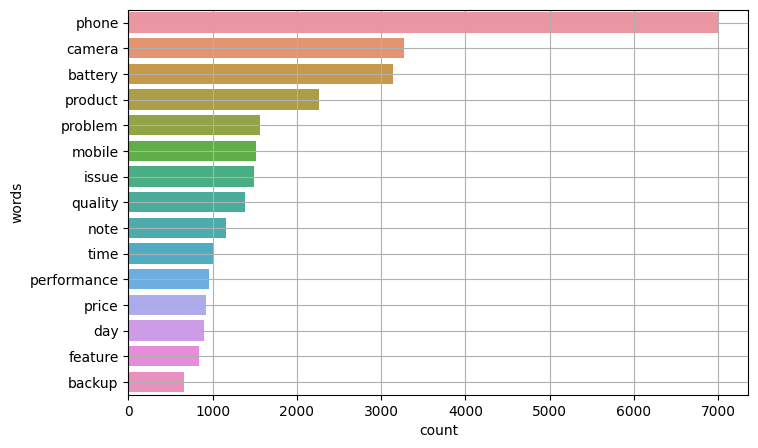

In [24]:
## Plot the top most common word occurrence

# Create a dictionary from the first 15 most common word counts 
top_words_dict = {word:count for word, count in word_counts.most_common(15)}

# Create a DataFrame with the words and count dictionary
df_top_words = pd.DataFrame({'words':list(top_words_dict.keys()), 'count':list(top_words_dict.values())})
df_top_words                             

# Plot the bar chart showing the most common word counts
plt.figure(figsize=[8,5])
sns.barplot(data=df_top_words, x='count', y='words').grid();

#### Show the most common words as a WordCloud

In [25]:
## Combine the content of all of the nouns into one string
noun_text = ' '.join(word for word in all_nouns)

## Create wordcloud object
wordcloud = WordCloud(colormap='coolwarm', background_color='black').generate(noun_text)

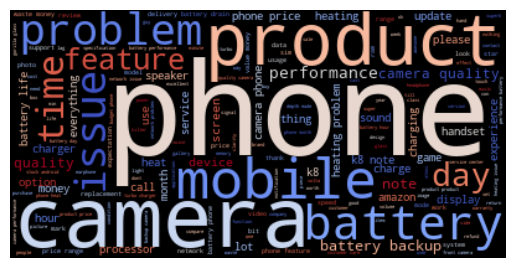

In [26]:
## Visualize wordcloud object
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
## Create a topic dataframe with the cleaned, tokenized nouns reviews converted to String dtype

# Copy the original DataFrame to start off
tp = data.copy()

# Replace the 'review' column with the review nouns
tp['review'] = [' '.join(review_nouns) for review_nouns in cleaned_tokens]

# Show the first 5 rows of the topic dataframe
tp.head()

,sentiment,review
0,1,update improvement
1,0,mobile battery hell backup hour us idle discha...
2,1,cash
3,1,
4,0,phone phone problem amazon phone amazon


#### Check if need to clean up topic dataframe
- It is possible to have no noun only reviews in the topic dataframe.
- Remove these records with no noun only reviews from the dataframe.

In [28]:
## Drop the rows in the topic dataframe that has no review after filtering for nouns only

# Get the index of the rows that has no (empty) reviews
empty_review_rows = [i for i in range(tp.shape[0]) if len(tp['review'][i]) == 0]

# Drop these rows from the tp dataframe and reset the index
tp = tp.drop(empty_review_rows).reset_index(drop=True)

# Show that the empty review rows had been remvoed from the dataframe
print('The dataframe had been reduced to', tp.shape, 'rows and columns.\n')

# Show the first 5 rows of the dataframe
tp.head()


The dataframe had been reduced to (13076, 2) rows and columns.



,sentiment,review
0,1,update improvement
1,0,mobile battery hell backup hour us idle discha...
2,1,cash
3,0,phone phone problem amazon phone amazon
4,0,money


There are 13,076 nouns-only reviews after preprocessing.

#### Step 2 and 3 : Convert document text to `Document-Term` matrix and fit the instantiated LDA model with it
- Use the `CountVectorizer` to convert the collection of text documents (reviews) to a matrix of token counts.
- Fit and transform the vectorized token counts to create a `term-frequency` matrix.
- Instantiate the LDA model (sklearn.decomposition.LatentDirichletAllocation)
- Fit the LDA model with the vectorized matrix of tokens converted by the CountVectorizer.

In [29]:
# 8. Create a topic model using LDA on the cleaned-up data with 12 topics.

# Topics 
n_topics = 12
n_features = 10000

## Use tf_lda (document-term) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95,  
                                min_df=2,
                                max_features=n_features,
                                stop_words='english')

## Learn the vocabulary dictionary and return document-term matrix
tf_lda = tf_vectorizer.fit_transform(tp['review'])
                                     
## Setup LDA model
print("\nFitting LDA models with tf features...\n")
lda = LatentDirichletAllocation(n_components=n_topics, 
                                learning_method='online',
                                learning_offset=40.0,
                                max_iter=100,
                                random_state=0)

## Fit the LDA model with the TF matrix (features)
lda.fit(tf_lda)


Extracting tf features for LDA...

Fitting LDA models with tf features...



LatentDirichletAllocation(learning_method='online', learning_offset=40.0,
                          max_iter=100, n_components=12, random_state=0)

#### Interpreting the Meanings of Topics
- This is the most crucial step in topic modeling. The LDA does not give us a label for each topic.
- It is the analyst who determines the meanings of the topics.
- These decisions are based on the words under each topic that show high importance weights.


In [30]:
# This function sorts the words importances under each topic
## and the selectional criteria include (a) ranks based on weights, or (b) cutoff on weights
def get_topics_meanings(topic_word_matrix, vocab, display_weights=False, top_n=5, weight_cutoff=0.6):
    # Get the topics from the topic_word_matrix and vocab
    topics = get_topics(topic_word_matrix, vocab)

    # If weights are to be displayed
    if display_weights:
        for i, topic in enumerate(topics):
            ## output words whose weights > weight_cutoff (value)
            topic = [item for item in topic if item[1] > weight_cutoff]  
            print(f"Topic #{i+1} :\n{topic}")
            print("=" * 57)
    else:
        topic_str = get_topics_str(topics, top_n)
        for i, topic in enumerate(topic_str):
            print(f"Topic {i+1} : {topic}")

            
## Function to get topics
def get_topics(topic_word_matrix, vocab):
    topics = []
    for i, topic_weights in enumerate(topic_word_matrix):  ## for each topic row
        topic = [(token, np.round(weight, 2)) 
                 for token, weight in zip(vocab, topic_weights)] ## zip (word, importance_weight)
        
        topic = sorted(topic, key=lambda x: -x[1])  ## rank words according to weights
        topics.append(topic)
    return topics


## Function to get the topics as strings
def get_topics_str(topics, top_n=5, sep=' '):
    topic_str = []  
    for i, topic in enumerate(topics):
        topic_top_n = topic[:top_n]
        topic_top_n = sep.join([word for word, weight in topic_top_n])
        topic_str.append(topic_top_n)
    return topic_str

In [31]:
# 8A. Print out the top terms for each topic.

## Get the output transformed feature names (ndarray of str objects)
lda_feature_names = tf_vectorizer.get_feature_names_out() 

## Get the LDA components
lda_components = lda.components_

# Show the top 10 words
n_top_words = 10

print(sbold + 'Showing the top', n_top_words, 'terms for each topic' + ebold)

## To show the top n words for each topic, specify top_n=n and display_weights=False
get_topics_meanings(topic_word_matrix=lda_components, vocab=lda_feature_names, display_weights=False, top_n=n_top_words)


Showing the top 10 terms for each topic
Topic 1 : problem experience battery application company touch key till fast time
Topic 2 : phone feature camera sound quality delivery budget look earphone thanks
Topic 3 : screen speaker glass display star processor super use core music
Topic 4 : option light model video flash notification way message ho result
Topic 5 : mobile note k8 charger month sim handset turbo slot card
Topic 6 : charging mark cast expectation contact ok need feature item sensor
Topic 7 : money device waste charge hour value work data power replacement
Topic 8 : issue phone battery heating network time update heat drain lot
Topic 9 : product price service amazon day customer range return time support
Topic 10 : speed excellent setting fine working net bahut par disappointment log
Topic 11 : purchase headphone effect good piece set point month cover hi
Topic 12 : camera battery quality performance backup day phone mode price life


In [32]:
# Print out the top terms for each topic with its weight

print(sbold + 'Displaying the Topics with its term weight (cutoff at 30)' + ebold)
print('='* 57)

# Specify weight_cutoff value if display_weights=True
get_topics_meanings(topic_word_matrix=lda_components, vocab=lda_feature_names, display_weights=True, weight_cutoff=30)


Displaying the Topics with its term weight (cutoff at 30)
Topic #1 :
[('problem', 1636.29), ('experience', 328.8), ('battery', 209.54), ('application', 113.92), ('company', 104.19), ('touch', 97.86), ('key', 92.76), ('till', 90.98), ('fast', 73.68), ('time', 71.02), ('buy', 67.85), ('music', 67.26), ('finger', 62.98), ('auto', 61.77), ('print', 59.06), ('player', 42.48), ('change', 41.95), ('lock', 41.69), ('sensor', 40.99), ('configuration', 40.35), ('party', 35.9), ('seller', 34.1)]
Topic #2 :
[('phone', 5456.12), ('feature', 704.43), ('camera', 485.83), ('sound', 381.28), ('quality', 247.45), ('delivery', 222.46), ('budget', 189.88), ('look', 174.56), ('earphone', 146.15), ('thanks', 131.22), ('clarity', 131.16), ('box', 111.08), ('atmos', 110.75), ('voice', 107.25), ('function', 96.21), ('version', 91.21), ('condition', 85.91), ('amazon', 77.78), ('specification', 72.06), ('recorder', 70.92), ('memory', 67.52), ('hanging', 63.99), ('buy', 61.44), ('spec', 60.23), ('rate', 48.02), (

In [33]:
# visualize top words for each model

def plot_top_words(model, feature_names, model_components, n_top_words, title):
    ## Create subplot of 2 rows and 6 columns
    fig, axes = plt.subplots(2, 6, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    ## For each of the topic, plot the number of top words specified
    for topic_idx, topic in enumerate(model_components):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 25})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=35)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

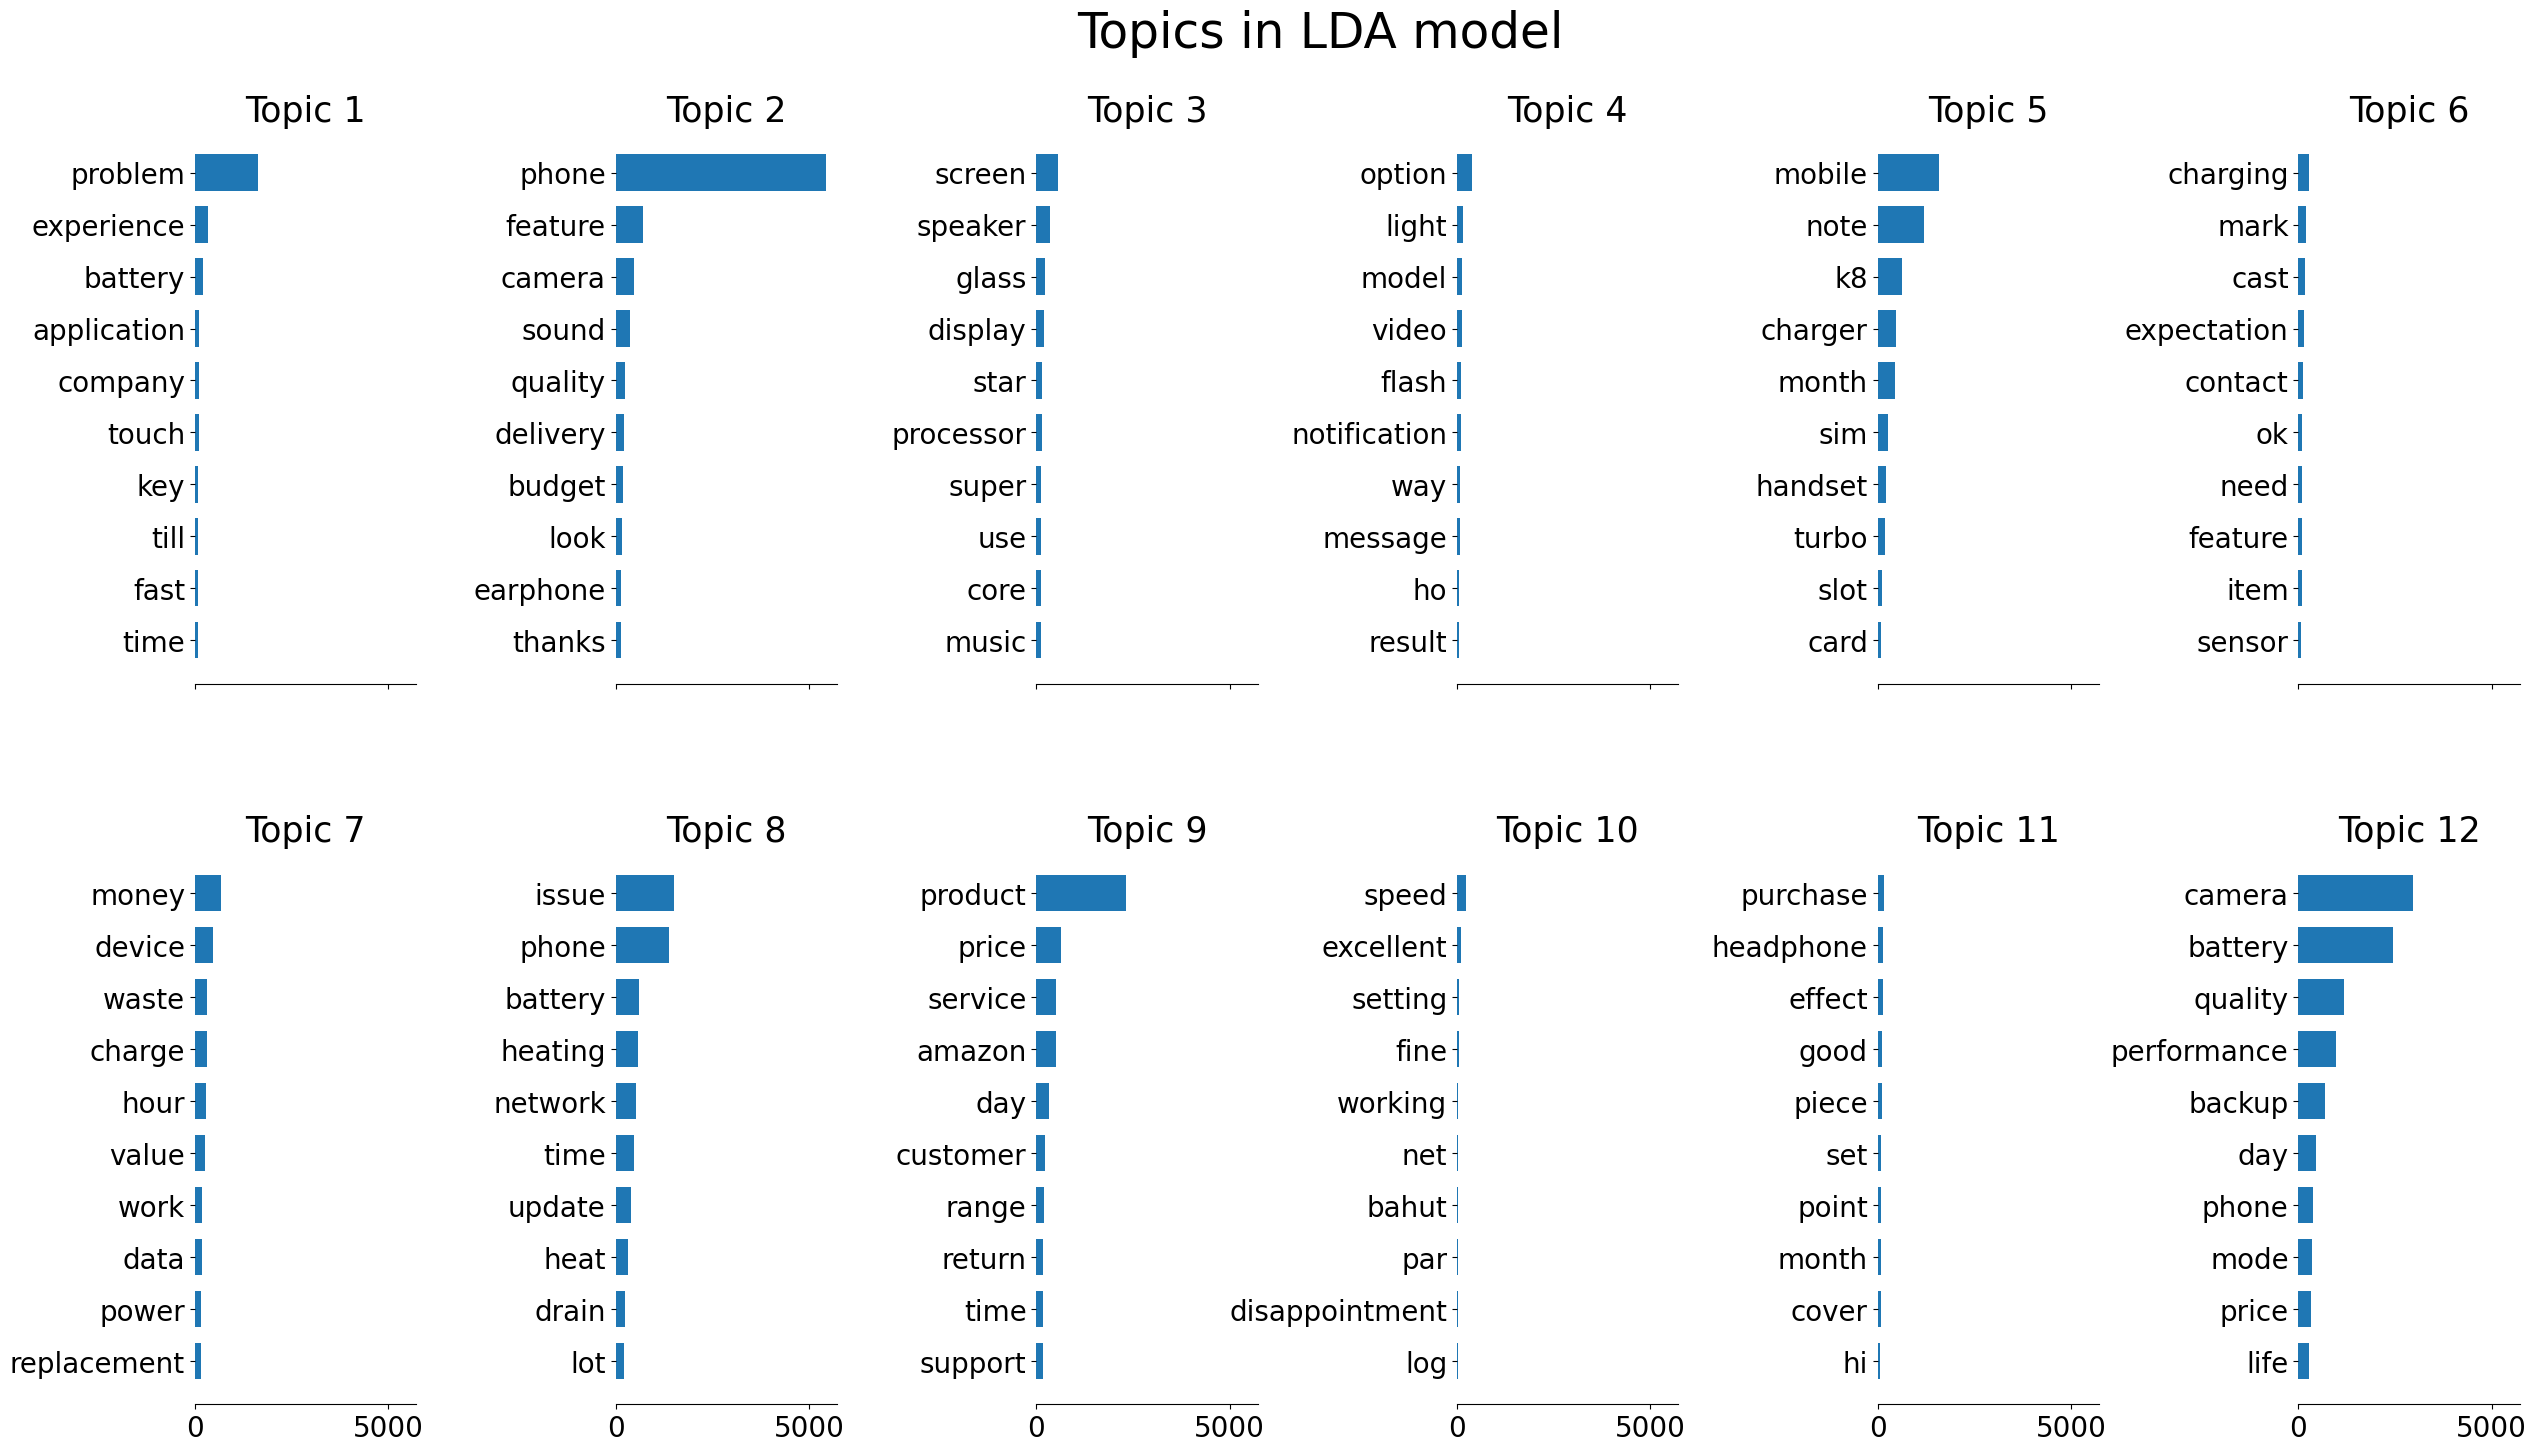

In [34]:
# Plot the top words for each topics in the LDA model
plot_top_words(lda, lda_feature_names, lda_components, n_top_words, 'Topics in LDA model')

### Coherence Metrics
**CV** Coherence score, in topic modeling is used to measure how interpretable the topics are to humans. `c_v` creates content vectors of words using their co-occurrences and, after that, calculates the score using normalized pointwise mutual information (NPMI) and the cosine similarity, that is, the coherence score measures how similar the top N words are to each other.

C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity


In [35]:
# 8B. What is the coherence of the model with the c_v metric?

# Tokenize cleaned up corpus
tp_tokens = [doc.split() for doc in tp['review']]

# c_v coherence
coherence_per_topic = metric_coherence_gensim(measure='c_v', 
                                              topic_word_distrib=lda_components, 
                                              dtm=tf_lda, 
                                              vocab=np.array(lda_feature_names), 
                                              texts=tp_tokens,
                                              top_n=n_top_words)


print(sbold + 'The coherence of the model with the c_v metric for each of the topics are:' + ebold)
coherence_per_topic

The coherence of the model with the c_v metric for each of the topics are:


[0.48477017261610894,
 0.5251478915202438,
 0.6056165620811625,
 0.48785916565717347,
 0.576162451525082,
 0.35783412608489884,
 0.5938979115153875,
 0.6425041600856602,
 0.6632288375665818,
 0.441018637672023,
 0.38194059045277007,
 0.6689798908766749]

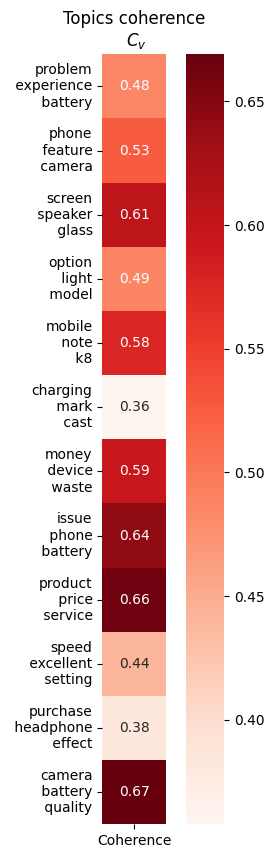

In [36]:
# Get only the first 3 words in each topic
topics = get_topics(lda_components, lda_feature_names)
topics_str = get_topics_str(topics, top_n=3, sep='\n ')

df_topic_score = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Coherence'] )
df_topic_score = df_topic_score.set_index('Topic')

fig, ax = plt.subplots( figsize=(5,10) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=df_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

### 9. Analyze the topics through the business lens.

|**Topic** |**Coherence Score (c_v)**|**Words**                     | **Most Important Words Score**|**Topic Name**|
|:--------:|:---------------------:|:-----------------------------|:------------------------------|:-------------|
| 1  | 0.48477 |problem experience battery application company touch key till fast time |('problem', 1636.29), ('experience', 328.8), ('battery', 209.54)|Problems |
| 2  | 0.52514 |phone feature camera sound quality delivery budget look earphone thanks |('phone', 5456.12), ('feature', 704.43), ('camera', 485.83)     |Phone    |
| 3  | 0.60561 |screen speaker glass display star processor super use core music        |('screen', 564.64), ('speaker', 365.11), ('glass', 220.82)      |Hardware |
| 4  | 0.48785 |option light model video flash notification way message ho result       |('option', 398.83), ('light', 144.04), ('model', 132.87)        |Options  |
| 5  | 0.57616 |mobile note k8 charger month sim handset turbo slot card                | ('mobile', 1598.2), ('note', 1208.37), ('k8', 628.52)          |Mobile   |
| 6  | 0.35783 |charging mark cast expectation contact ok need feature item sensor      |('charging', 270.73), ('mark', 186.39), ('cast', 160.87)        |Charging |
| 7  | 0.59389 |money device waste charge hour value work data power replacement        |('money', 666.98), ('device', 457.23), ('waste', 317.62)        |Value    |
| 8  | 0.64250 |issue phone battery heating network time update heat drain lot          |('issue', 1516.51), ('phone', 1389.83), ('battery', 610.03)     |Issues   | 
| 9  | 0.66322 |product price service amazon day customer range return time support     |('product', 2312.98), ('price', 632.05), ('service', 509.62)    |Product  |
| 10 | 0.44101 |speed excellent setting fine working net bahut par disappointment log   |('speed', 231.73), ('excellent', 112.12), ('setting', 49.0)     |Speed    |
| 11 | 0.38194 |purchase headphone effect good piece set point month cover hi           |('purchase', 160.06), ('headphone', 145.1), ('effect', 129.4)   |Purchase |
| 12 | 0.66897 |camera battery quality performance backup day phone mode price life     |('camera', 2956.95), ('battery', 2438.57), ('quality', 1168.86) |Camera   |

##### Topic 1 : Problems
- The coherence score is 0.48, the words are not very related but it did seems to be complains about problems encountered with the battery and having negative experience with either the phone or the company, probably the customer service

##### Topic 2 : Phone
- The coherence score for this topic is 0.53. Some of the important words point to the features of the phone, features like the camera, sound, earphone. Some words refers to the quality, budget, delivery and look of the phone. The words sound positive. Probably providing good reviews for the phone. 
    
##### Topic 3 : Hardware
- The coherence score for this topic is 0.61 and the words are more or less related to the hardware of the phone, words like screen, display, speaker, processor, core.
    
##### Topic 4 : Options
- The coherence score for this topic is 0.49. The words are more or less related to the extra options of the phone. Options like having light, a certain model, video functionality, flash, notification and message.
    
##### Topic 5 : Mobile
- This topic has coherence score of 0.58. The words are correlated with the hardware for the mobile phone, features like k8 processor, charger, SIM, handset, slot card and turbo functionality.
    
##### Topic 6 : Charging
- This topic has the lowest coherence score of 0.36. The words are not really correlated.
    
##### Topic 7 : Value
- This topic has coherence score of 0.59. The words are more or less related to the value of the phone. The mention of the words money, waste and replacement could meant that the reviews might be more negative than positive.
    
##### Topic 8 : Issues
- The coherence score for this topic is 0.64. The words are correlated with the problem of the phone battery and heating issue. It seems there are complains about the battery draining and heating up. There might be complain about network connections as well.
    
##### Topic 9 : Product
- The coherence score for this topic is on the high side of 0.66. The words are correlated to the product, customer service and support provided by Amazon. 
    
##### Topic 10 : Speed
- The coherence score for this topic is 0.44. The words are hardly correlated. There are positive workds like excellent, fine, working and negative words like disappointment.
    
##### Topic 11 : Purchase
- The coherence score for this topic is the lowest, 0.38. The weight for the most important word in this topic is only 160.06. If there is any correlation of words in this topic, it probably to refer to the headphone and its good effect.
    
##### Topic 12 : Camera
- This topic has the highest coherence score of 0.67. The words are correlated with the camera and battery quality and performance. 

### 9A. Determine which of the topics can be combined.
- `Topic 1 (Problems), topic 7 (Value), topic 8 (Issues) and topic 9 (Product)` can be combined as Customer Service and Support to answer the query about any problems and issues that need to be resolved. It however can be subdivided to items that need attention or just reviews that gave good feedback.

- `Topic 2 (Phone), topic 3 (Hardware), topic 4 (Options), topic 5 (Mobile) and topic 12 (Camera)` can be combined as reviews provided for the features and functionality of the phone. It also can be subdivided into positive and negative reviews.

- `Topic 6 (Charging), topic 10 (Speed) and topic 11 (Purchase)` can be combined. These topics are unclear what the reviews are about.

### Find the model with the optimal number of topics

In [37]:
# Grid search to find the best model

# Define Search Parameters
search_params = {'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'learning_decay': [.5, .7, .9]}

# Initialze the model
lda_grid = LatentDirichletAllocation(learning_method='online',
                                     learning_offset=40.0,
                                     max_iter=100,
                                     random_state=0)

# Initialze Grid Search 
model = GridSearchCV(lda_grid, search_params)

# Get the best model and metrics
model.fit(tf_lda)
best_lda_model = model.best_estimator_

# Show the best parameter of the model and its best score 
print(sbold + "Best model's params: " + ebold, model.best_params_)
print(sbold + "Best log likelihood score: " + ebold, model.best_score_)
print(sbold + "Model perplexity: " + ebold, best_lda_model.perplexity(tf_lda))

Best model's params:  {'learning_decay': 0.5, 'n_components': 2}
Best log likelihood score:  -82217.50871711863
Model perplexity:  220.61110031770744


In [38]:
## Print out the top terms for each topic with its weight for the best lda model
print(sbold + 'Showing the top terms with its weights (cutoff at 70) for the best LDA model' + ebold)
print('='* 76)
get_topics_meanings(topic_word_matrix=best_lda_model.components_, vocab=lda_feature_names, display_weights=True, weight_cutoff=70)


Showing the top terms with its weights (cutoff at 70) for the best LDA model
Topic #1 :
[('battery', 2640.11), ('phone', 2487.07), ('product', 2297.0), ('problem', 1643.09), ('mobile', 1592.82), ('issue', 1493.34), ('time', 1012.22), ('day', 921.75), ('backup', 669.41), ('amazon', 608.25), ('heating', 580.44), ('network', 558.22), ('month', 510.14), ('service', 502.85), ('hour', 496.96), ('charger', 478.0), ('money', 416.55), ('waste', 325.94), ('heat', 317.92), ('charge', 306.26), ('use', 298.42), ('note', 292.82), ('device', 285.36), ('charging', 268.55), ('sim', 258.3), ('k8', 251.57), ('drain', 239.15), ('life', 237.63), ('turbo', 230.09), ('delivery', 229.69), ('customer', 224.54), ('experience', 224.46), ('handset', 218.19), ('update', 205.7), ('lot', 199.48), ('return', 180.82), ('replacement', 176.46), ('data', 170.26), ('support', 161.65), ('star', 156.95), ('usage', 156.47), ('purchase', 156.33), ('center', 143.68), ('thanks', 131.75), ('week', 129.97), ('box', 120.77), ('pie

#### Analyze the 2 topics from the best model from GridSearch
As with the manual analysis of the topics `through business lens`, the topics are mainly grouped into 2.

##### Topic 1
- This topic is more or less related to problem and issues that customer service and support will need to attend to.

##### Topic 2
- This topic is more or less related to the phone features like the camera, battery, screen, processor and its quality and performance.

In [39]:
# View details of the grid search
df_cv_results = pd.DataFrame(model.cv_results_)
df_cv_results.to_csv("LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,26.498492,1.296313,0.087000,0.003972,0.5,2,"{'learning_decay': 0.5, 'n_components': 2}",-83544.364141,-81839.276635,-82114.324341,-82857.306638,-80732.271830,-82217.508717,951.790085,1
1,24.761752,0.845023,0.080808,0.002098,0.5,3,"{'learning_decay': 0.5, 'n_components': 3}",-85141.667346,-83590.709020,-83806.346426,-84702.575625,-82526.706416,-83953.600967,912.345032,4
2,26.049662,0.558332,0.082123,0.003641,0.5,4,"{'learning_decay': 0.5, 'n_components': 4}",-87088.096798,-85026.417266,-85530.376869,-86295.244629,-84250.319523,-85638.091017,984.482043,8
3,25.607978,1.095967,0.078959,0.003100,0.5,5,"{'learning_decay': 0.5, 'n_components': 5}",-88126.380229,-86073.175722,-86350.907979,-87208.962791,-85153.049550,-86582.495254,1013.153144,11
4,27.155014,0.496546,0.082900,0.002986,0.5,6,"{'learning_decay': 0.5, 'n_components': 6}",-88984.439422,-87061.681260,-87329.297226,-88292.677789,-86097.502304,-87553.119600,1000.605072,15
5,25.847331,0.436715,0.079253,0.001687,0.5,7,"{'learning_decay': 0.5, 'n_components': 7}",-89869.472860,-88024.250394,-88233.449787,-88996.463653,-86938.707571,-88412.468853,981.696930,18
6,25.714758,0.470620,0.083265,0.004996,0.5,8,"{'learning_decay': 0.5, 'n_components': 8}",-90150.226921,-88776.250937,-88959.408255,-89959.834775,-87853.456803,-89139.835538,838.189419,22
7,26.110483,0.495414,0.080927,0.002616,0.5,9,"{'learning_decay': 0.5, 'n_components': 9}",-90796.207889,-88619.841268,-88996.749752,-90063.547761,-87876.861304,-89270.641595,1038.964293,24
8,26.816083,0.551028,0.079543,0.001642,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-91232.610011,-89839.079314,-90038.365243,-91226.798074,-88909.307602,-90249.232049,886.651583,27
9,25.665089,0.912770,0.082240,0.000963,0.7,2,"{'learning_decay': 0.7, 'n_components': 2}",-83573.921624,-81863.048413,-82127.705799,-82855.433335,-80702.301766,-82224.482187,967.069741,2


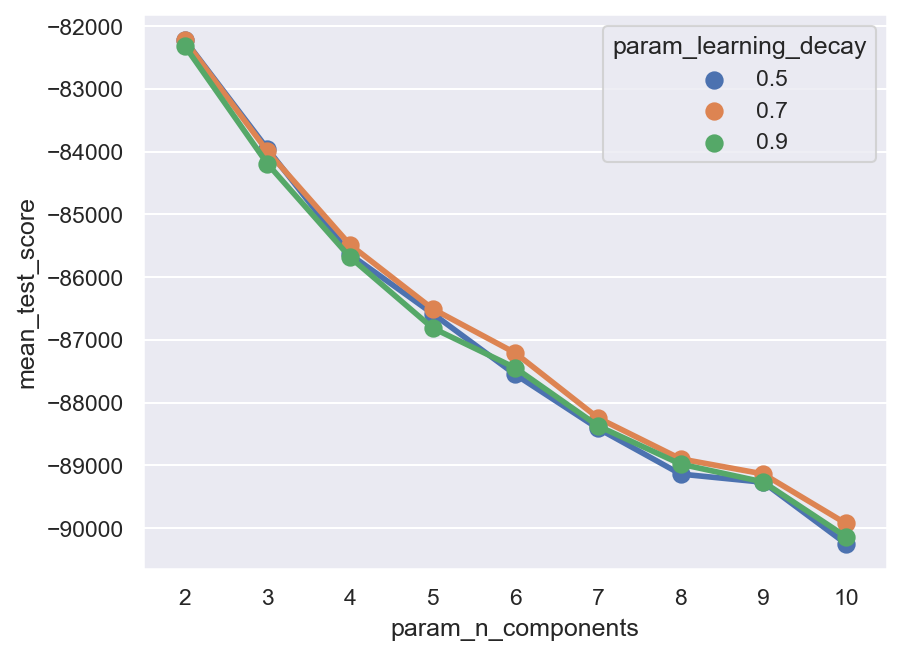

In [40]:
# Visualize details of other models 
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results);

In [41]:
# Function to find the optimal topic number based on the coherence scores of the topic models.
# Source from https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/nlp/topic-modeling-naive.html

def topic_model_coherence_generator(topic_num_start=2, topic_num_end=6, 
                                    norm_corpus='', cv='', top_n=5):
    # Result variables
    models = []
    coherence_scores = []

    # CountVectorizer
    cv_matrix = cv.fit_transform(norm_corpus)
    cv_feature_names = cv.get_feature_names_out()
    
    # Tokenize corpus
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]

    for i in range(topic_num_start, topic_num_end):
        cur_lda = LatentDirichletAllocation(n_components=i,
                                            max_iter=100,
                                            random_state=0)
        
        cur_lda.fit_transform(cv_matrix)
        
        # Get the c_v coherence score for current
        cur_coherence_score = metric_coherence_gensim(measure='c_v', 
                                                      topic_word_distrib=cur_lda.components_,
                                                      dtm=cv_matrix,
                                                      vocab=np.array(cv_feature_names),
                                                      texts=norm_corpus_tokens,
                                                      top_n=top_n)
        # Save model
        models.append(cur_lda)
        # Save coherence score
        coherence_scores.append(np.mean(cur_coherence_score))
        
    return models, coherence_scores

In [42]:
num_topic_start = 2  # (inclusive) Starts with 2 number of topics
num_topic_end = 12   # (exclusive) End with 11 number of topics

num_top_words = 10

# Find the optimal number of topics based on the mean of the coherence scores of the topic models
models, coherence_scores = topic_model_coherence_generator(topic_num_start=num_topic_start, 
                                                           topic_num_end=num_topic_end, 
                                                           norm_corpus=tp['review'], 
                                                           cv=tf_vectorizer,
                                                           top_n=num_top_words)


In [43]:
# Showing the mean coherence scores for each of the number of topics.
print(sbold + 'Mean Coherence Scores for each model' + ebold)
coherence_scores


Mean Coherence Scores for each model


[0.6105728589560944,
 0.6371487868767804,
 0.626203327449227,
 0.6629665888187731,
 0.681589086228014,
 0.6114149225683833,
 0.6270872831607905,
 0.6056573327712191,
 0.5592573089526477,
 0.5803721540874688]

In [44]:
# Create a dataFrame to show the number of topics used for the model with its mean coherence scores
df_coherence = pd.DataFrame({'Number of Topics used in Model': [str(i) for i in range(num_topic_start, num_topic_end)], 
                             'Mean Coherence Score': np.round(coherence_scores, 4)})

# Display the dataFrame with the coherence score sorted in descending order
df_coherence.sort_values(by=['Mean Coherence Score'], ascending=False)


,Number of Topics used in Model,Mean Coherence Score
4,6,0.6816
3,5,0.6630
1,3,0.6371
6,8,0.6271
2,4,0.6262
5,7,0.6114
0,2,0.6106
7,9,0.6057
9,11,0.5804
8,10,0.5593


### Create the topic model using LDA with the optimal number of topics
- Using the `topic_model_coherence_generator()` function, it was found that the `optimal number of topics is 6` with a `mean coherence score of 0.6816`.
- The models and its mean coherence scores are returned in the function call as lists of models and coherence scores.

In [45]:
# 10. Create topic model using LDA with what you think is the optimal number of topics

optimal_model = models[4]   # the optimal model is at index 4
optimal_model

LatentDirichletAllocation(max_iter=100, n_components=6, random_state=0)

In [46]:
# 10A. What is the coherence of the model?

print(sbold + 'The coherence of the model is:' + ebold, coherence_scores[4])

The coherence of the model is: 0.681589086228014


In [47]:
# 11. The business should be able to interpret the topics.
#   A. Name each of the identified topics.

print(sbold + 'The top 10 terms for each of the topics' + ebold)
# Show the top 10 words for each topic
get_topics_meanings(topic_word_matrix=optimal_model.components_, vocab=lda_feature_names, display_weights=False, top_n=10)

The top 10 terms for each of the topics
Topic 1 : battery problem phone issue backup heating day network life hour
Topic 2 : phone camera quality price performance feature range processor mode sound
Topic 3 : phone time charger money day issue value update turbo hour
Topic 4 : note k8 speaker device option screen feature cast earphone network
Topic 5 : mobile camera quality sim music video photo android display stock
Topic 6 : product amazon service waste money delivery glass customer experience return


In [48]:
# Show the topics with the weights
print(sbold + 'Display the terms with weights cutoff at 70 for each of the topics' + ebold)
get_topics_meanings(topic_word_matrix=optimal_model.components_, vocab=lda_feature_names, display_weights=True, weight_cutoff=70)

Display the terms with weights cutoff at 70 for each of the topics
Topic #1 :
[('battery', 3261.16), ('problem', 1611.16), ('phone', 1174.87), ('issue', 1103.46), ('backup', 675.16), ('heating', 578.16), ('day', 392.43), ('network', 367.4), ('life', 347.16), ('hour', 293.3), ('month', 285.88), ('time', 255.0), ('drain', 243.16), ('performance', 225.63), ('handset', 179.73), ('use', 159.39), ('usage', 158.58), ('update', 147.54), ('mah', 134.16), ('lot', 123.05), ('heat', 121.58), ('charging', 108.03), ('charge', 102.47), ('display', 102.28), ('game', 99.64)]
Topic #2 :
[('phone', 4188.13), ('camera', 2766.4), ('quality', 1074.5), ('price', 951.16), ('performance', 769.7), ('feature', 557.42), ('range', 390.16), ('processor', 322.16), ('mode', 243.35), ('sound', 217.71), ('budget', 192.16), ('depth', 175.16), ('look', 151.13), ('effect', 131.16), ('super', 122.17), ('mark', 121.32), ('ram', 107.88), ('specification', 106.21), ('core', 104.95), ('thing', 99.58), ('display', 97.21), ('gam

#### Name each of the identified topics
- Topic 1 - Issues
- Topic 2 - Quality
- Topic 3 - Value
- Topic 4 - Hardware Components
- Topic 5 - Features
- Topic 6 - Product Services

In [49]:
# 11 B. Create a table with the topic name and the top 10 terms in each to present to the business.

# Get the top 10 words in each topic
optimal_topics = get_topics(optimal_model.components_, lda_feature_names)
topics_terms = get_topics_str(optimal_topics, top_n=10)

# Create a dataframe with the Topic Name and its top 10 terms
df_topics = pd.DataFrame({'Topic': range(1, 7),
                          'Topic Name': ['Issues','Quality','Value','Hardware Components','Features','Product Services'],
                          'Top 10 Terms': topics_terms}
                        ).style.set_properties(**{'text-align': 'left'}                             ## Align text in cell left
                                              ).set_table_styles([{'selector': 'th.col_heading', 
                                                                   'props': 'text-align: left'}])   ## Align header left

# Set to show the maximum column width so all 10 terms can be seen
pd.set_option('max_colwidth', None)

# Show the topic name and its top 10 terms as a table
df_topics

,Topic,Topic Name,Top 10 Terms
0,1,Issues,battery problem phone issue backup heating day network life hour
1,2,Quality,phone camera quality price performance feature range processor mode sound
2,3,Value,phone time charger money day issue value update turbo hour
3,4,Hardware Components,note k8 speaker device option screen feature cast earphone network
4,5,Features,mobile camera quality sim music video photo android display stock
5,6,Product Services,product amazon service waste money delivery glass customer experience return


<center><b>End of Project</b></center>